# Adsorption of a square-well fluid in a pore

In this notebook, we will demonstrate how to perform active learning to map out the adsorption curve of a square-well fluid in a pore. Data from many such active learning runs will be collected and used to compare various active learning strategies.

In [1]:
import sys, os
import glob
import numpy as np
import xarray as xr

import thermoextrap

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from thermoextrap.gpr_active import active_utils
from thermoextrap.gpr_active import gp_models

## Preliminaries

Define some constants related to the square-well fluid. Note that these are also defined in example_projects/gpr_active_learning/run_active_adsorption.py.

In [2]:
kBT_over_eps = 0.12500e01
eps_over_kB = 0.10000e03  # Assuming units of Kelvin
kB = 1.380649e-23  # In units of Joules / Kelvin
eps = eps_over_kB * kB
beta = 1.0 / (eps * kBT_over_eps)
sigma = 0.30000e01  # Angstroms
lnZeta = -0.268000e01  # Equal to beta*mu for the bulk reference simulation
muRef = lnZeta * kBT_over_eps  # In units of the LJ epsilon

Next, it will be helpful to have a function to load in the macrostate distributions we will use as our data source.

In [3]:
def get_lnPi(
    mu,
    file_str=os.path.expanduser(
        "SWF_Adsorption_data/sw_t125/t125.h0900_l10.ew_50.r*.lnpi.dat"
    ),
):
    files = glob.glob(file_str)
    dat = np.array([np.loadtxt(f) for f in files])
    Nvals = dat[:, :, 0]
    lnPi = dat[:, :, 1]
    # lnPi_err = np.var(dat[:, :, 1], axis=0)
    # Adjust to desired chemical potential
    lnPi = lnPi + (1.0 / kBT_over_eps) * (mu - muRef) * Nvals
    return Nvals, lnPi

To get a sense for the system, let's first load in our macrostate distributions and take a look at them. We will plot the distributions for the fluid in the pores as solid colored lines at a variety of chemical potentials and also plot $\ln \Pi$ for the bulk fluid at the same chemical potentials as black-dashed lines. With increasing chemical potential, the distributions will be tilted up at more of an incline.

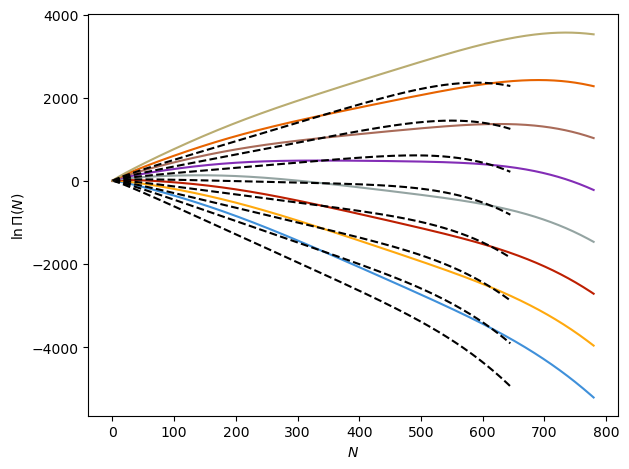

In [4]:
# Plot lnPi curves, both inside pore and in bulk
fig, ax = plt.subplots()

for m in np.arange(-12, 3.8, 0.1):
    Nbulk, lnPibulk = get_lnPi(
        m,
        file_str=os.path.expanduser("SWF_Adsorption_data/sw_t125/t125.v729.b.lnpi.dat"),
    )
    N, lnPi = get_lnPi(m)

    if np.around(m, 3) % 2 == 0.0:
        ax.plot(N.T[:, 0], (lnPi.T - lnPi[:, 0])[:, 0], label="%f" % m)
        ax.plot(Nbulk.T, lnPibulk.T - lnPibulk[:, 0], "k--")

ax.set_xlabel(r"$N$")
ax.set_ylabel(r"$\ln \Pi (N)$")

fig.tight_layout()

plt.show()

For our GPR modeling and active learning target, we will focus on the adsorption isotherm, or the average number of particles adsorbed in the pore as a function of chemical potential. With knowledge of the chemical potential and the bulk macrostate distribution at the same temperature, this can be related to a bulk pressure of the adsorbing species. For our purposes, we only focus on learning how the average number of particles changes with the chemical potential.

To make this work, we will need a custom `DataWrapper` class. This will actually be simpler than the typical `DataWrapper` class because we are not loading data from a simulation that we have to process. Instead, we just need to load a macrostate distribution and adjust it to the proper chemical potential. From the macrostate distribution, it is straightforward to compute the average number of particles adsorbed in a pore - it is simply the average $N$ weighted by the probabilities $\Pi (N)$ for which we know the relative (unnormalized) log-probabilities $\ln \Pi (N)$. Interestingly, this is also sufficient information to compute the derivative of the average number of particles, which is related to the variance of $N$ given the distribution. More generally, higher order derivatives are related to moments of $N$ and $-\beta N$, where $\beta = \frac{1}{k_\mathrm{B}T}$ is the reciprocal temperature. As described in [this paper](https://aip.scitation.org/doi/abs/10.1063/5.0014282), $\langle N \rangle$ is the average property of interest and $-\beta N$ takes the place of the potential energy for the purposes of computing derivatives.

In [5]:
class Adsorption_DataWrapper(active_utils.DataWrapper):
    def __init__(self, mu):
        self.lnPi_files = os.path.expanduser(
            "SWF_Adsorption_data/sw_t125/t125.h0900_l10.ew_50.r*.lnpi.dat"
        )
        self.beta = mu  # Calling it beta for compatibility, but it's really mu

    def load_U_info(self):
        raise NotImplementedError

    def load_CV_info(self):
        raise NotImplementedError

    def load_x_info(self):
        raise NotImplementedError

    def get_data(self):
        # Instead of returning U, X, and weights, return -beta*N, N, and weights for each N
        # Averaging those should give the appropriate moments in N and beta*N
        N, lnPi = get_lnPi(self.beta, file_str=self.lnPi_files)
        lnPi = lnPi - lnPi[:, :1]
        maxProb = np.amax(lnPi, axis=1, keepdims=True)
        weights = np.exp(lnPi - maxProb)
        weights = weights / np.sum(weights, axis=1, keepdims=True)
        beta_N = xr.DataArray((1.0 / kBT_over_eps) * N, dims=["rep", "n"])
        N = xr.DataArray(N[:, :, None], dims=["rep", "n", "val"])
        weights = xr.DataArray(weights, dims=["rep", "n"])
        return -beta_N, N, weights

    def build_state(self, all_data=None, max_order=6):
        if all_data is None:
            all_data = self.get_data()
        u_vals = all_data[0]
        x_vals = all_data[1]
        weights = all_data[2]
        # Build raw moments array
        moments = np.ones((x_vals["rep"].shape[0], 2, max_order + 1))
        for i in range(2):
            for j in range(max_order + 1):
                moments[:, i, j] = (
                    ((x_vals**i) * (u_vals**j) * weights)
                    .sum("n", keep_attrs=False)
                    .values.flatten()
                )
        moments = xr.DataArray(
            moments[:, np.newaxis, :, :], dims=["rec", "val", "xmom", "umom"]
        )
        state_data = thermoextrap.DataCentralMoments.from_raw(moments)
        state = thermoextrap.beta.factory_extrapmodel(self.beta, state_data)
        return state

To accompany our `DataWrapper` class, we need a function to create data. This is typically done by running a simulation, but here it's as easy as loading an $\ln \Pi$ distribution at a specific chemical potential and providing the associated `DataWrapper` object. This is a highly simplified version of the `SimWrapper` class in `active_utils`, but accomplishes the same goal - here it's just way easier.

In [6]:
class SimulateAdsorption:
    def __init__(self, sim_func=None):
        self.sim_func = sim_func  # Will not perform any simulations

    def run_sim(self, unused, mu, n_repeats=None):
        # All this does is creates an Adsorption_DataWrapper object at the specified chemical potential and returns it
        del unused
        return Adsorption_DataWrapper(mu)

Now we can calculate isotherms. Below, we plot the adsorption isotherm and its derivative with respect to the chemical potential $\mu$. The uncertainties (standard deviations) associated with each average value of $N$ in the isotherm are plotted on the right. Uncertainties are computed over three independent simulation runs to compute the macrostate distributions, with the standard deviation calculated for the computed average $N$ at a given chemical potential.

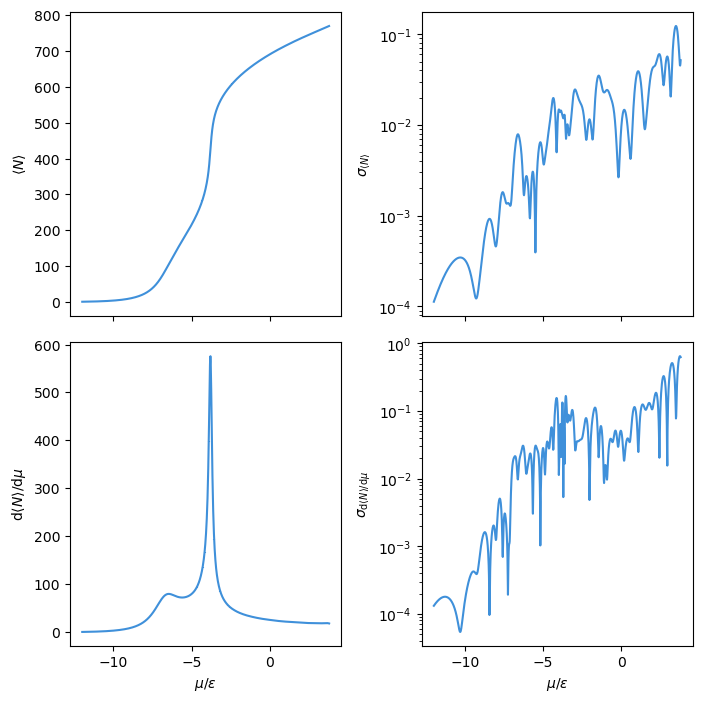

In [7]:
# To look at convergence, compute absorption curves with uncertainties at many mu values
mu_plot = np.linspace(-12.0, 3.8, 1000)
ads_vals = np.zeros((mu_plot.shape[0], 2))
ads_derivs = np.zeros((mu_plot.shape[0], 2))

for i, m in enumerate(mu_plot):
    this_dat = SimulateAdsorption().run_sim(None, m)
    this_coefs = this_dat.build_state(max_order=1).derivs(norm=False)
    this_means = this_coefs.mean("rec").values
    this_stds = np.sqrt(this_coefs.var("rec").values)
    ads_vals[i, 0] = this_means[0, 0]
    ads_vals[i, 1] = this_stds[0, 0]
    ads_derivs[i, 0] = this_means[1, 0]
    ads_derivs[i, 1] = this_stds[1, 0]

fig, ax = plt.subplots(2, 2, sharex=True, sharey=False, figsize=(7.13, 7.13))

ax[0, 0].errorbar(mu_plot, ads_vals[:, 0], yerr=ads_vals[:, 1])
ax[1, 0].errorbar(mu_plot, ads_derivs[:, 0], yerr=ads_derivs[:, 1])

ax[0, 1].plot(mu_plot, ads_vals[:, 1])
ax[1, 1].plot(mu_plot, ads_derivs[:, 1])

ax[0, 0].set_ylabel(r"$\langle N \rangle$")
ax[1, 0].set_ylabel(r"$\mathrm{d}\langle N \rangle / \mathrm{d} \mu$")
ax[1, 0].set_xlabel(r"$\mu / \epsilon$")

ax[0, 1].set_ylabel(r"$\sigma_{\langle N \rangle}$")
ax[1, 1].set_ylabel(r"$\sigma_{\mathrm{d}\langle N \rangle / \mathrm{d} \mu}$")
ax[1, 1].set_xlabel(r"$\mu / \epsilon$")

ax[0, 1].set_yscale("log")
ax[1, 1].set_yscale("log")

fig.tight_layout()

plt.show()

When we want to compare our GPR models to the ground truth, it will be helpful to have a function that represents it, at least for the adsorption isotherm. That function will be an interpolating polynomial based on the data just plotted.

In [8]:
from scipy import interpolate

# Create a function we can use as the ground truth to compare to
ground_truth_ads = interpolate.interp1d(mu_plot, ads_vals[:, 0], kind="cubic")

## Active learning

At this point, we are ready to perform active learning. This is a pedogogical reproduction of the function `run_active` in `run_active_adsorption.py` within the directory example_projects.

First we need to define how the update will be performed. Here we will use maximum variance updates, though other possibilities are random or space-filling. This can be modified by changing the update function, with a number of options in `active_utils`.

In [9]:
update_func = active_utils.UpdateALMbrute(
    save_plot=False,  # Will not save plots
    show_plot=True,  # But will show them in notebook
    compare_func=ground_truth_ads,
    avoid_repeats=True,  # Here, running "more simulations" won't reduce uncertainty, so don't bother
)

Next, we will set up all of the stopping metrics we want to compute, along with the `StopCriteria` class wrapper that determines if the metrics have been satisfied. Note that we actually include a `MaxIter` metric, which can never be satisfied and will ensure that the maximum number of active learning iterations is reached. You can always include this metric as a simple way to change the behavior of the active learning algorithm. Otherwise, convergence is defined as the point when all metrics are simultaneously satisfied at the specified tolerances (the only argument passed to each metric). All metrics may be found in the `active_utils` module.

In [10]:
# Set up list of metrics to compute
metrics = [
    active_utils.MaxVar(1e-03),
    active_utils.MaxRelVar(1e-02),
    active_utils.AvgVar(1e-03),
    active_utils.AvgRelVar(1e-02),
    active_utils.MSD(1e-01),
    active_utils.MaxAbsRelDeviation(1e-02),
    active_utils.AvgAbsRelDeviation(1e-02),
    active_utils.ErrorStability(1e-02),
    active_utils.MaxRelGlobalVar(1e-02),
    active_utils.MaxAbsRelGlobalDeviation(1e-02),
    active_utils.MaxIter(),
]
# And stopping criteria function wraps metrics
stop_func = active_utils.StopCriteria(metrics)

And run active learning! In the paper, we used 50 iterations, but here will just do 5 since we want this to be a quick tutorial. Note that we will in fact have the update function plot the iterations and information will be printed as we go.



Initial mu values:  [-12.0, 3.8]
Metal device set to: Apple M2

Current GP info: 
╒═══════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤══════════╕
│ name                                      │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │    value │
╞═══════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪══════════╡
│ HeteroscedasticGPR.kernel.kernel.var      │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 0.706654 │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ HeteroscedasticGPR.kernel.kernel.l        │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 7.12763  │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──────────┤
│ HeteroscedasticGPR.likeli

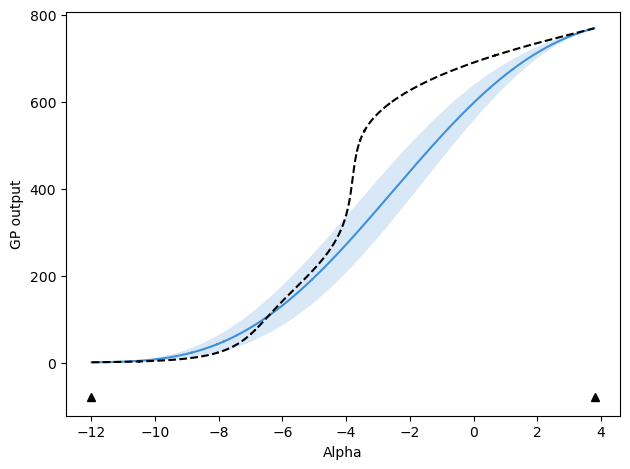


After 1 updates, mu values are: 
[-12.0, 3.8, -3.1695703617068625]

Current GP info: 
╒═══════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                                      │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═══════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ HeteroscedasticGPR.kernel.kernel.var      │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 0.796786    │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ HeteroscedasticGPR.kernel.kernel.l        │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.31565     │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ H

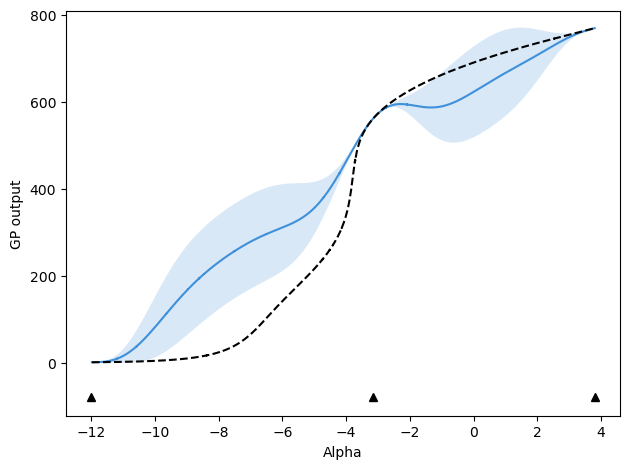


After 2 updates, mu values are: 
[-12.0, 3.8, -3.1695703617068625, -7.589422539806207]

Current GP info: 
╒═══════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                                      │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═══════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ HeteroscedasticGPR.kernel.kernel.var      │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.16547 │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ HeteroscedasticGPR.kernel.kernel.l        │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 2.54837 │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ Heterosce

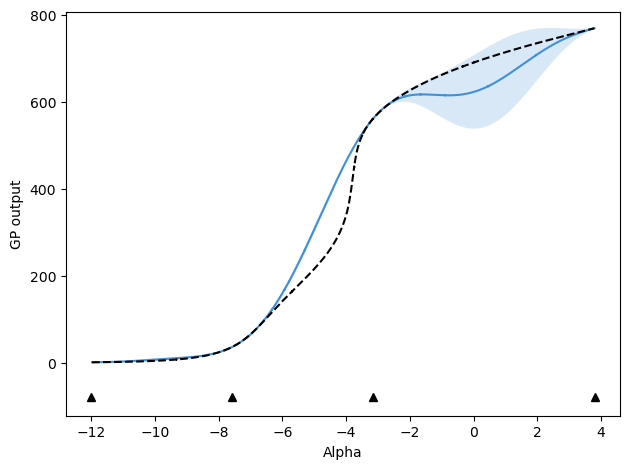


After 3 updates, mu values are: 
[-12.0, 3.8, -3.1695703617068625, -7.589422539806207, 0.6132640502804736]

Current GP info: 
╒═══════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                                      │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═══════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ HeteroscedasticGPR.kernel.kernel.var      │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.10664 │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ HeteroscedasticGPR.kernel.kernel.l        │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 2.44882 │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼──

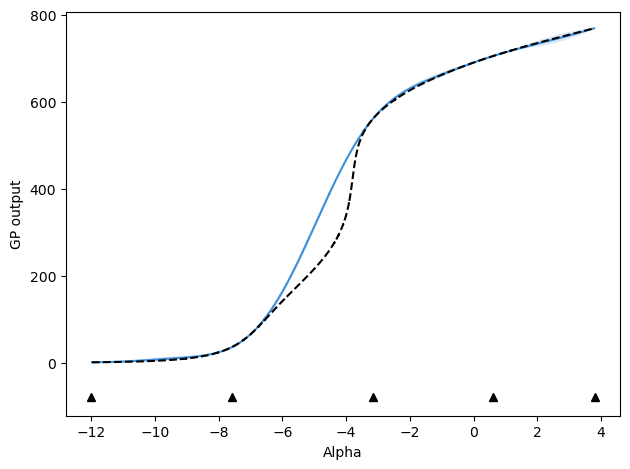


After 4 updates, mu values are: 
[-12.0, 3.8, -3.1695703617068625, -7.589422539806207, 0.6132640502804736, 2.6549411015242947]

Current GP info: 
╒═══════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════╕
│ name                                      │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │   value │
╞═══════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════╡
│ HeteroscedasticGPR.kernel.kernel.var      │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 1.29579 │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────┤
│ HeteroscedasticGPR.kernel.kernel.l        │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 2.47153 │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼──

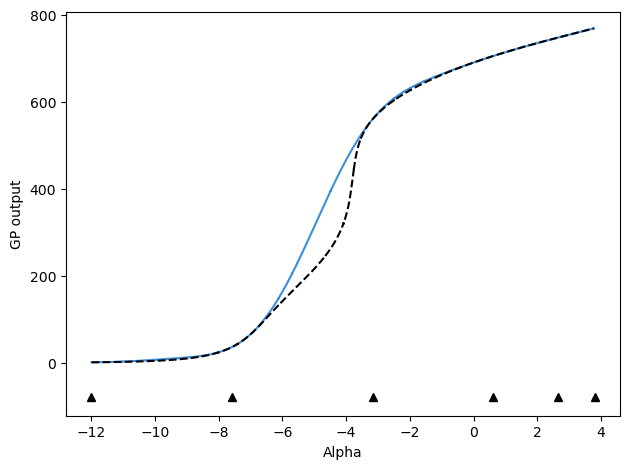


After 5 updates, mu values are: 
[-12.0, 3.8, -3.1695703617068625, -7.589422539806207, 0.6132640502804736, 2.6549411015242947, -5.2698371497200425]

Current GP info: 
╒═══════════════════════════════════════════╤═══════════╤═════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════╕
│ name                                      │ class     │ transform   │ prior   │ trainable   │ shape   │ dtype   │       value │
╞═══════════════════════════════════════════╪═══════════╪═════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════╡
│ HeteroscedasticGPR.kernel.kernel.var      │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 0.749811    │
├───────────────────────────────────────────┼───────────┼─────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────┤
│ HeteroscedasticGPR.kernel.kernel.l        │ Parameter │ Softplus    │         │ True        │ ()      │ float64 │ 0.959127    │
├───────────────────────────────────────────┼───────

In [11]:
dat_list, train_history = active_utils.active_learning(
    [-12.0, 3.8],  # Initial values of chemical potentials
    SimulateAdsorption(),  # Function to perform "simulation," really just return DataWrapper
    update_func,
    stop_criteria=stop_func,
    max_iter=5,
    alpha_name="mu",  # Just the name of the input parameter to the GP model, here chemical potential
    max_order=2,  # Maximum order of derivatives to be used
    gp_base_kwargs={},  # If we want to change the kernel, can do that here by specifying keyword arguments for creating GP model
)

## Comparison of active learning strategies

We repeated the above procedure many times and for different active learning strategies. Specifically, we used maximum variance, space-filling, and random updates. We also explored two different types of kernels described in the paper, the standard kernel and a change-points kernel that applies different kernels to different regions of chemical potential space. As we will show, this significant accelerates active learning because such a model better represents the function to be fit. Specifically, we need rapid function variations at intermediate chemical potentials, with small kernel length scale parameter values, while the function varies slowly with large kernel length scale values at low and high chemical potentials. Without a change-points kernel, sampling new points within the middle of the chemical potential range results in reductions of the kernel length-scale that then cause large increases in uncertainty and oscillations at low and high chemical potentials. This cycle keeps repeating, in the end requiring lots of data points over the entire range due to the GPR model learning that a small length-scale is necessary. A change-points kernel avoids this by only requiring many data points for intermediate chemical potentials.

The first thing is to load all of the data. Note that for a small number of runs, data is not available because a numerical instability while creating a GPR model. This can happen for a variety of reasons, but is most likely due to sampling of chemical potentials that are very similar to each other with a large kernel lengthscale. Such behavior is far more likely for a random update strategy that does not make use of prior information to help drive exploration of the space. It is also more likely for a change-points kernel using a space-filling update strategy, where the scenario of the sampled points being too close to the points at which the kernel changes can also lead to instabilities.

In [12]:
# Load all the data that we'll need
# Identify directory where data is held
base_dir = os.path.expanduser("SWF_Adsorption_data")

# And all run directories
run_dirs = glob.glob("%s/run*" % base_dir)
run_dirs.sort()

# Define methods used for updates/models
method_names = ["alm", "random", "space_fill", "changepoints_alm", "changepoints_space"]

# Collect training information
train_info_dict = {}
for m_name in method_names:
    train_info_dict[m_name] = []
    for rdir in run_dirs:
        try:
            train_info_dict[m_name].append(
                np.load("%s/%s/active_history.npz" % (rdir, m_name))
            )
        except IOError:
            print("File not found in %s/%s" % (rdir, m_name))

File not found in SWF_Adsorption_data/run18/alm
File not found in SWF_Adsorption_data/run65/alm
File not found in SWF_Adsorption_data/run7/alm
File not found in SWF_Adsorption_data/run18/random
File not found in SWF_Adsorption_data/run32/random
File not found in SWF_Adsorption_data/run37/random
File not found in SWF_Adsorption_data/run65/random
File not found in SWF_Adsorption_data/run7/random
File not found in SWF_Adsorption_data/run73/random
File not found in SWF_Adsorption_data/run92/random
File not found in SWF_Adsorption_data/run18/space_fill
File not found in SWF_Adsorption_data/run65/space_fill
File not found in SWF_Adsorption_data/run7/space_fill
File not found in SWF_Adsorption_data/run18/changepoints_space
File not found in SWF_Adsorption_data/run65/changepoints_space
File not found in SWF_Adsorption_data/run7/changepoints_space


The following reproduces Figure 6 from the paper, using the same data. The top panel plots the GPR models compared to the ground truth, with locations of sampling indicated at the bottom of the plot with markers. The bottom panel shows the uncertainty predicted by the models, along with the uncertainty in the provided average number of particles at each chemical potential.

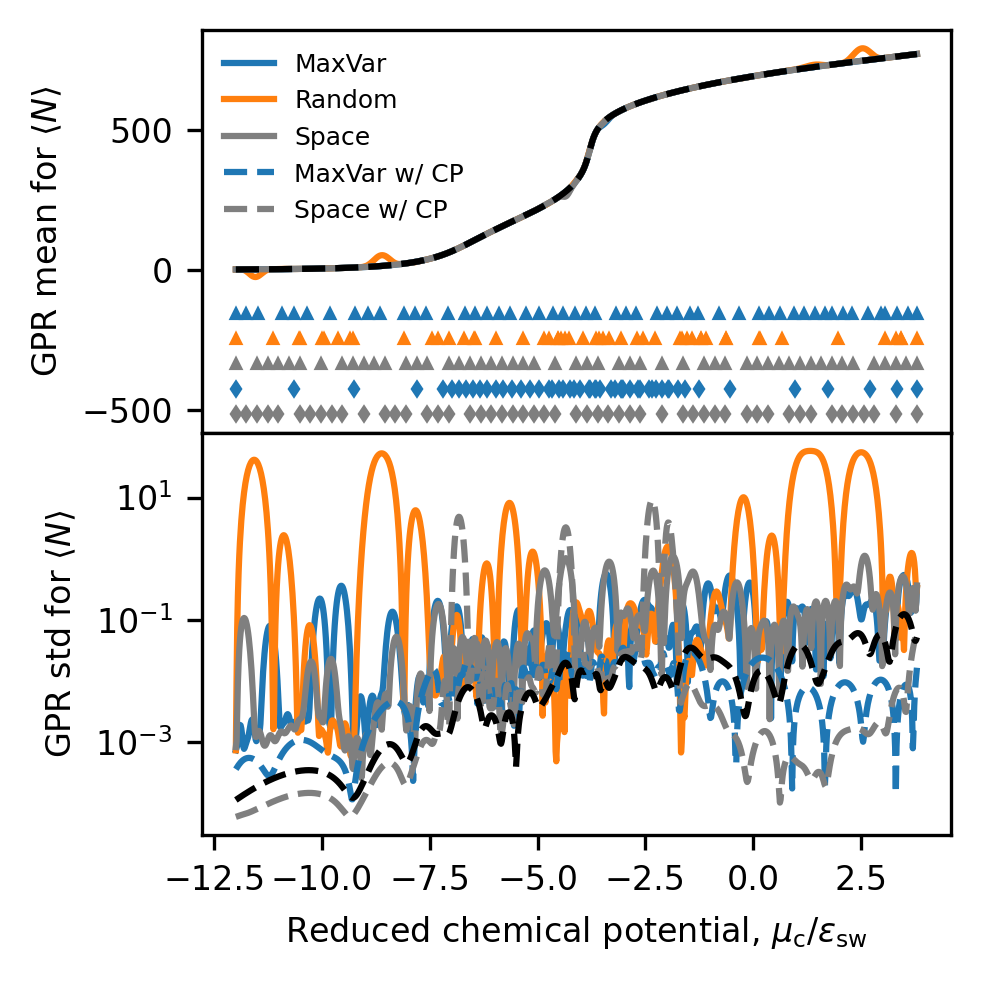

In [13]:
# All final models (values, not derivatives)
fig, ax = plt.subplots(2, sharex=True, figsize=(3.37, 3.37), dpi=300)

train_colors = ["tab:blue", "tab:orange", "tab:gray", "tab:blue", "tab:gray"]
train_labels = ["MaxVar", "Random", "Space", "MaxVar w/ CP", "Space w/ CP"]
line_styles = ["-", "-", "-", "--", "--"]
marker_styles = ["^", "^", "^", "d", "d"]

alpha_vals_list = []
for i, m_name in enumerate(method_names):
    t_info_list = train_info_dict[m_name]
    this_mu = np.array([t_info["pred_mu"][-1, :] for t_info in t_info_list])
    this_avg_mu = np.average(this_mu, axis=0)
    this_std = np.array([t_info["pred_std"][-1, :] for t_info in t_info_list])
    this_alpha = t_info_list[0]["alpha"]
    this_alpha_grid = np.linspace(this_alpha.min(), this_alpha.max(), this_mu.shape[1])
    ax[0].plot(
        this_alpha_grid,
        this_mu[0, :],
        label=train_labels[i],
        color=train_colors[i],
        linestyle=line_styles[i],
    )  # , alpha=0.3)
    ax[1].plot(
        this_alpha_grid,
        this_std[0, :],
        label=train_labels[i],
        color=train_colors[i],
        linestyle=line_styles[i],
    )  # , alpha=0.3)
    alpha_vals_list.append(this_alpha)

# After plotting ALL other curves, plot alphas based on automatic y limits
y_lims = ax[0].get_ylim()
for i, this_alpha in enumerate(alpha_vals_list):
    ax[0].plot(
        this_alpha,
        (y_lims[0] - (i + 1) * 0.10 * (y_lims[1] - y_lims[0]))
        * np.ones_like(this_alpha),
        marker=marker_styles[i],
        color=train_colors[i],
        linestyle="",
        markersize=2,
    )

ax[0].legend(frameon=False, fontsize=6, loc=2)

ax[0].plot(mu_plot, ads_vals[:, 0], "k--")
ax[1].plot(mu_plot, ads_vals[:, 1], "k--")

for a in ax:
    a.yaxis.set_major_locator(MaxNLocator(prune="both", nbins=3))
    a.tick_params(axis="both", labelsize=8)

ax[-1].set_xlabel(
    r"Reduced chemical potential, $\mu_\mathrm{c} / \epsilon_\mathrm{sw}$", fontsize=8
)

ax[0].set_ylabel(r"GPR mean for $\langle N \rangle$", fontsize=8)
ax[1].set_ylabel(r"GPR std for $\langle N \rangle$", fontsize=8)

ax[1].set_yscale("log")

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

We next reproduce Figure 7, where we compare convergence to the ground truth for all of our active learning methods and our two types of kernels. Each panel shows a different metric for assessing distance from the ground truth. 

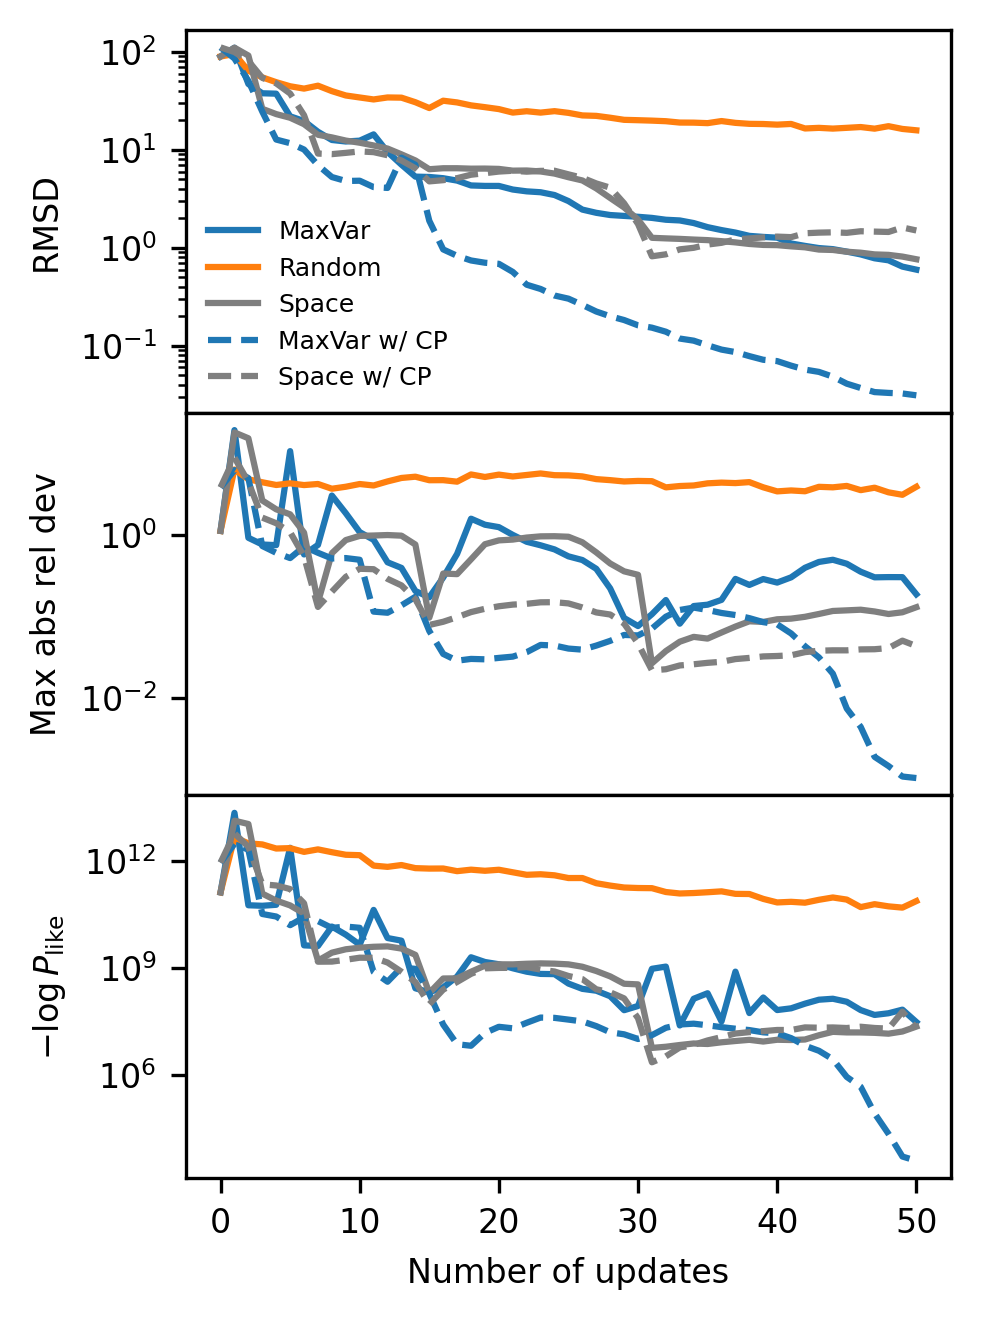

In [14]:
# Have intentionally set mu_plot so that will be same as values used to evaluate GP models in training histories
# So can compare distance to ground truth versus update iteration
fig, ax = plt.subplots(3, sharex=True, sharey=False, figsize=(3.37, 1.5 * 3), dpi=300)

train_colors = ["tab:blue", "tab:orange", "tab:gray", "tab:blue", "tab:gray"]
train_labels = ["MaxVar", "Random", "Space", "MaxVar w/ CP", "Space w/ CP"]
line_styles = ["-", "-", "-", "--", "--"]

for i, m_name in enumerate(method_names):
    t_info_list = train_info_dict[m_name]
    this_mean = np.array([t_info["pred_mu"][..., 0] for t_info in t_info_list])
    this_std = np.array([t_info["pred_std"][..., 0] for t_info in t_info_list])
    this_max_rel_dev = np.max(
        abs(this_mean - ads_vals[:, 0]) / abs(ads_vals[:, 0]), axis=-1
    )
    this_rmsd = np.sqrt(np.average(((this_mean - ads_vals[:, 0])) ** 2, axis=-1))
    this_gt_logprob = np.sum(
        0.5 * ((this_mean - ads_vals[:, 0]) / ads_vals[:, 1]) ** 2
        + np.log(ads_vals[:, 1]),
        axis=-1,
    )
    ax[0].plot(
        np.average(this_rmsd, axis=0),
        color=train_colors[i],
        linestyle=line_styles[i],
        label=train_labels[i],
    )
    ax[1].plot(
        np.average(this_max_rel_dev, axis=0),
        color=train_colors[i],
        linestyle=line_styles[i],
        label=train_labels[i],
    )
    ax[2].plot(
        np.average(this_gt_logprob, axis=0),
        color=train_colors[i],
        linestyle=line_styles[i],
        label=train_labels[i],
    )

ax[0].legend(fontsize=6, frameon=False)

ax[-1].set_xlabel("Number of updates", fontsize=8)
ax[0].set_ylabel("RMSD", fontsize=8)
ax[1].set_ylabel(r"Max abs rel dev", fontsize=8)
ax[2].set_ylabel(r"$-\log P_\mathrm{like}$", fontsize=8)

for a in ax:
    a.set_yscale("log")
    a.tick_params(axis="both", labelsize=8)

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

plt.show()

Next, we reproduce Figure 8 from the paper, showing the behavior of different metrics that could be used to define stopping criteria without prior knowledge of the ground truth.

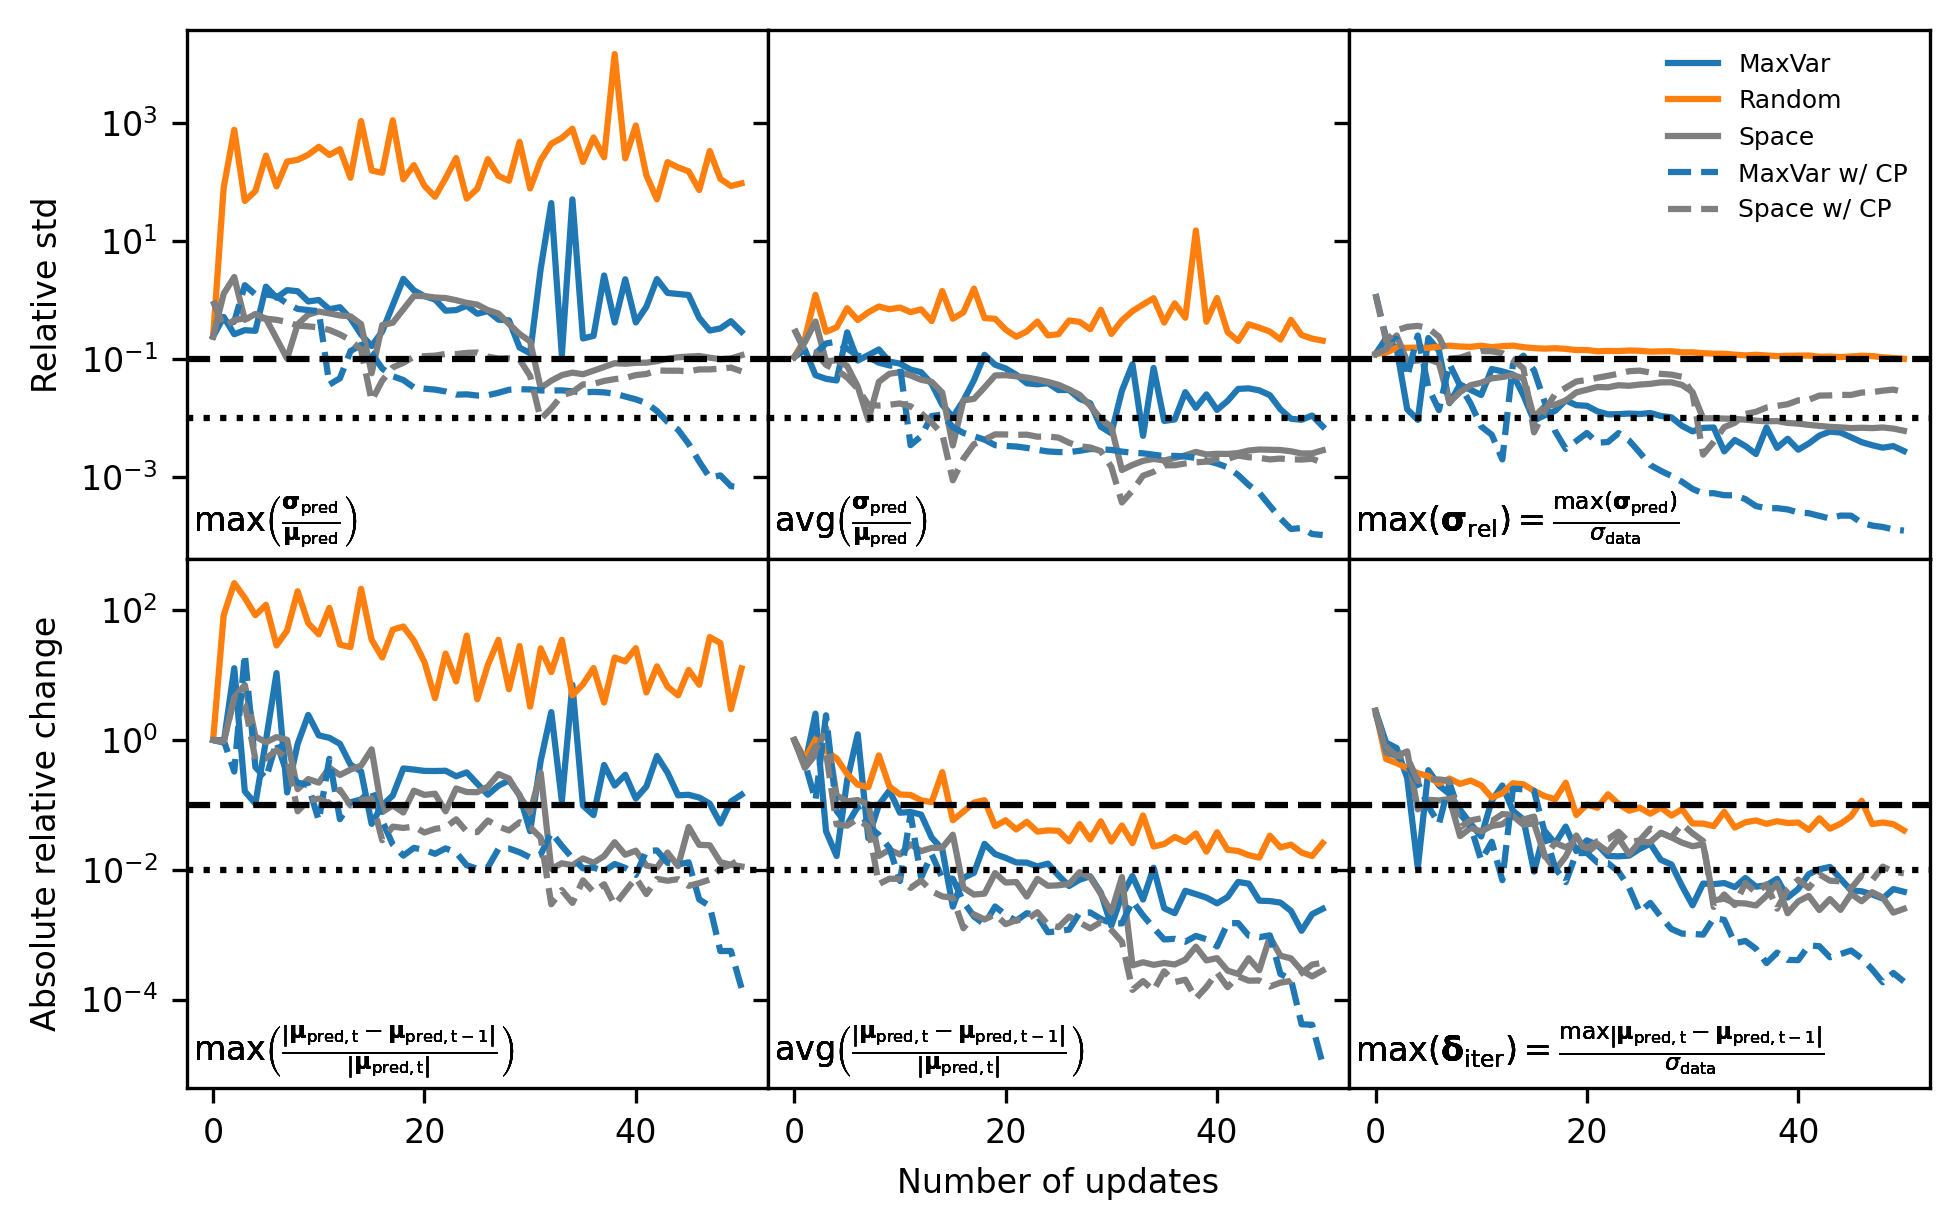

In [15]:
# Plot stopping criteria metrics over update iterations
metric_names = [
    "MaxRelVar",
    "AvgRelVar",
    "MaxRelGlobalVar",
    "MaxAbsRelDev",
    "AvgAbsRelDev",
    "MaxAbsRelGlobalDeviation",
]
metric_labels = [
    r"$\mathrm{max} \left( \frac{\mathbf{\sigma}_\mathrm{pred}}{\mathbf{\mu}_\mathrm{pred}} \right)$",
    r"$\mathrm{avg} \left( \frac{\mathbf{\sigma}_\mathrm{pred}}{\mathbf{\mu}_\mathrm{pred}} \right)$",
    r"$\mathrm{max} \left( \mathbf{\sigma}_\mathrm{rel} \right) = \frac{ \mathrm{max} \left( \mathbf{\sigma}_\mathrm{pred} \right)}{\sigma_\mathrm{data}}$",
    r"$\mathrm{max} \left( \frac{\left| \mathbf{\mu}_\mathrm{pred, t} - \mathbf{\mu}_\mathrm{pred, t-1} \right|}{\left| \mathbf{\mu}_\mathrm{pred, t} \right|} \right)$",
    r"$\mathrm{avg} \left( \frac{\left| \mathbf{\mu}_\mathrm{pred, t} - \mathbf{\mu}_\mathrm{pred, t-1} \right|}{\left| \mathbf{\mu}_\mathrm{pred, t} \right|} \right)$",
    r"$\mathrm{max} \left( \mathbf{\delta}_\mathrm{iter} \right) = \frac{ \mathrm{max} \left| \mathbf{\mu}_\mathrm{pred, t} - \mathbf{\mu}_\mathrm{pred, t-1} \right|}{\sigma_\mathrm{data}}$",
]

fig, ax = plt.subplots(2, 3, sharex=True, sharey="row", figsize=(6.69, 4.2), dpi=300)

train_colors = ["tab:blue", "tab:orange", "tab:gray", "tab:blue", "tab:gray"]
train_labels = ["MaxVar", "Random", "Space", "MaxVar w/ CP", "Space w/ CP"]
line_styles = ["-", "-", "-", "--", "--"]

dat_std_y = np.std(train_info_dict["space_fill"][0]["pred_mu"][-1, ...], axis=0)

for i, m_name in enumerate(method_names):
    t_info_list = train_info_dict[m_name]
    for j, key in enumerate(metric_names):
        this_metric = np.array([t_info[key] for t_info in t_info_list])
        this_avg_metric = np.average(this_metric, axis=0)
        ax[j // 3, j % 3].plot(
            this_avg_metric,
            color=train_colors[i],
            linestyle=line_styles[i],
            label=train_labels[i],
        )  # , alpha=0.3)
        ax[j // 3, j % 3].annotate(
            metric_labels[j], xy=(0.01, 0.05), xycoords="axes fraction", fontsize=8
        )
        ax[j // 3, j % 3].tick_params(axis="both", labelsize=8)

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i, j].axhline(10e-02, color="k", linestyle="--")
        ax[i, j].axhline(1e-02, color="k", linestyle=":")
        ax[i, j].set_yscale("log")
#         ax[i, j].annotate(metric_names[i*3 + j], xy=(0.05, 0.85), xycoords='axes fraction')

# ax[-1, 0].set_xlabel(r'Number of updates')
ax[-1, 1].set_xlabel(r"Number of updates", fontsize=8)

ax[0, 0].set_ylabel(r"Relative std", fontsize=8)
ax[1, 0].set_ylabel(r"Absolute relative change", fontsize=8)

# ax[0, 0].set_title(r'Max local')
# ax[0, 1].set_title(r'Avg local')
# ax[0, 2].set_title(r'Max global')

ax[0, 2].legend(fontsize=6, frameon=False)

fig.tight_layout()
fig.subplots_adjust(hspace=0.0, wspace=0.0)

plt.show()

Finally, we also reproduce Figure S3 in the Supporting Information, which plots an additional, more sophisticated, stopping metric, that, though more seemingly more elegant, does not demonstrate significantly improved performance here. For random updates, this metric frequently becomes completely unstable after only a few iterations.

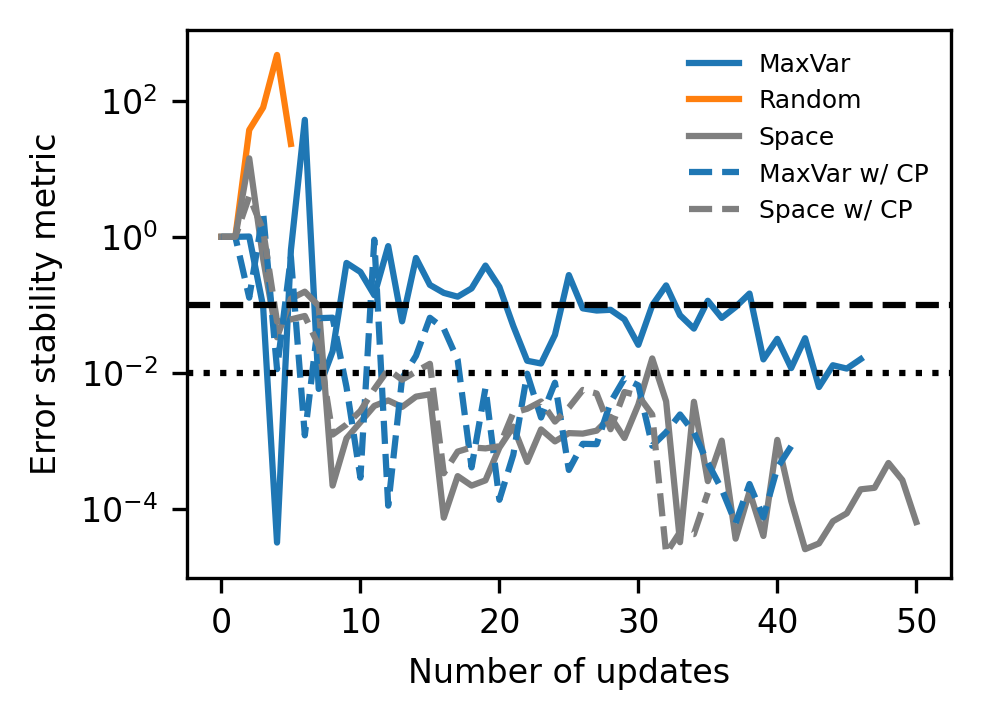

In [16]:
# Plot error stability metric versus iterations for SI
fig, ax = plt.subplots(figsize=(3.37, 2.5), dpi=300)

train_colors = ["tab:blue", "tab:orange", "tab:gray", "tab:blue", "tab:gray"]
train_labels = ["MaxVar", "Random", "Space", "MaxVar w/ CP", "Space w/ CP"]
line_styles = ["-", "-", "-", "--", "--"]

for i, m_name in enumerate(method_names):
    t_info_list = train_info_dict[m_name]
    this_metric = np.array([t_info["ErrorStability"] for t_info in t_info_list])
    this_avg_metric = np.average(this_metric, axis=0)
    ax.plot(
        this_avg_metric,
        color=train_colors[i],
        linestyle=line_styles[i],
        label=train_labels[i],
    )  # , alpha=0.3)

ax.axhline(10e-02, color="k", linestyle="--")
ax.axhline(1e-02, color="k", linestyle=":")
ax.set_yscale("log")

ax.tick_params(axis="both", labelsize=8)
ax.set_xlabel(r"Number of updates", fontsize=8)

ax.set_ylabel(r"Error stability metric", fontsize=8)

ax.legend(fontsize=6, frameon=False)

fig.tight_layout()

plt.show()